In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim

In [2]:
if torch.cuda.is_available():
    print("CUDA (GPU support) is available in PyTorch!")
else:
    print("CUDA (GPU support) is not available in PyTorch.")

CUDA (GPU support) is available in PyTorch!


In [3]:
torch.manual_seed(42)
np.random.seed(42)

In [48]:
class Puasson1DPINN(nn.Module):
    def __init__(self, layers):
        super(Puasson1DPINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(1, len(layers)):
            self.hidden_layers.append(nn.Linear(layers[i-1], layers[i]))

    def forward(self, x_t):
        for layer in self.hidden_layers[:-1]:
            x_t = torch.tanh(layer(x_t))
        output = self.hidden_layers[-1](x_t)
        # Placeholder for derivatives calculation, adjust as per your actual computation
        u_x = torch.autograd.grad(outputs=output, inputs=x_t, grad_outputs=torch.ones_like(output), create_graph=True)[0]
        return output, u_x

    def dirichlet_conditions(self, x_t_bc_top_bottom_1D, u_bc_top_bottom_1D):
        u, _ = self.forward(x_t_bc_top_bottom_1D)
        return torch.mean((u - u_bc_top_bottom_1D) ** 2)

    def neuman_conditions(self, x_t_bc_left_1D, x_t_bc_right_1D):
        alpha = 1
        u_left, u_x_left = self.forward(x_t_bc_left_1D)
        u_right, u_x_right = self.forward(x_t_bc_right_1D)
        return torch.mean((-u_x_left - alpha * u_left) ** 2) + torch.mean((u_x_right - 0) ** 2)

    def loss_fn(self, x_t_train, x_t_bc_top_bottom_1D, u_bc_top_bottom_1D, x_t_bc_left_1D, x_t_bc_right_1D):
        u, u_x = self.forward(x_t_train)
        # Placeholder for Poisson equation and f(x_t_train), adjust as per your actual computation
        a = 100
        poisson_eq = u - a * u_x ** 2  # This is a placeholder equation
        bc_dirichlet_loss = self.dirichlet_conditions(x_t_bc_top_bottom_1D, u_bc_top_bottom_1D)
        bc_neuman_loss = self.neuman_conditions(x_t_bc_left_1D, x_t_bc_right_1D)
        return torch.mean(poisson_eq**2) + bc_dirichlet_loss + bc_neuman_loss

In [49]:
def train(model, optimizer, loss_threshold, x_t_train, x_t_bc_top_bottom_1D, u_bc_top_bottom_1D, x_t_bc_left_1D, x_t_bc_right_1D, epochs=1000):
    model.train()  # Set the model to training mode (affects certain modules like Dropout, BatchNorm, etc.)
    optimizer.zero_grad()
    loss = model.loss_fn(x_t_train, x_t_bc_top_bottom_1D, u_bc_top_bottom_1D, x_t_bc_left_1D, x_t_bc_right_1D)
    epoch = 0

    while loss.item() > loss_threshold:
    #for epoch in range(epochs):
        optimizer.zero_grad()  # Clears old gradients from the last step (otherwise gradients would accumulate)
        
        # Compute the loss based on the provided training and boundary condition data
        loss = model.loss_fn(x_t_train, x_t_bc_top_bottom_1D, u_bc_top_bottom_1D, x_t_bc_left_1D, x_t_bc_right_1D)
        
        loss.backward()  # Backpropagate the loss to compute gradients
        optimizer.step()  # Adjust model parameters based on the computed gradients
        
        if epoch % 100 == 0:  # Optionally print the loss every 100 epochs
            print(f'Epoch {epoch}, Loss: {loss.item()}')

        if loss.item() < loss_threshold:  # If loss falls below threshold, stop training
            print(f'Training completed early at epoch {epoch} due to reaching loss threshold.')
            break

        epoch += 1
            
    print(f"Training completed in {epoch+1} epochs with final loss: {loss.item()}")


In [55]:
layers = [2, 20, 20, 1]  # Adjusted first layer to accept 2 inputs (x and t)
model = Puasson1DPINN(layers)
optimizer = optim.AdamW(model.parameters(), lr=5e-03)

# Example Data Preparation (Adapt this to your actual data)
N_train_x = 100
N_train_t = 100
N_bc = 100
L_x, R_x = 0.0, 1.0
L_t, R_t = 0.0, 1.0

x = np.linspace(L_x, R_x, N_train_x)
t = np.linspace(L_t, R_t, N_train_t)
X, T = np.meshgrid(x, t)
x_t_train = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
x_t_train = torch.tensor(x_t_train, dtype=torch.float32)

t_bc = np.linspace(L_t, R_t, N_bc)
x_t_bc_top = np.hstack((R_x * np.ones_like(t_bc)[:, None], t_bc[:, None]))
x_t_bc_bottom = np.hstack((L_x * np.ones_like(t_bc)[:, None], t_bc[:, None]))
x_t_bc_top_bottom_1D = np.vstack((x_t_bc_top, x_t_bc_bottom))
x_t_bc_top_bottom_1D = torch.tensor(x_t_bc_top_bottom_1D, dtype=torch.float32)

# Example u values for Dirichlet conditions, replace with actual functions f(t) and g(t)
u_bc_top = torch.ones(len(t_bc), 1)  # u = 1 at the top boundary
u_bc_bottom = torch.zeros(len(t_bc), 1)  # u = 0 at the bottom boundary

# Combine the top and bottom boundary conditions into one tensor
u_bc_top_bottom_1D = torch.cat([u_bc_bottom, u_bc_top], dim=0)

x_bc = np.linspace(L_x, R_x, N_bc)
x_t_bc_left = np.hstack((x_bc[:, None], L_t * np.ones_like(x_bc)[:, None]))
x_t_bc_right = np.hstack((x_bc[:, None], R_t * np.ones_like(x_bc)[:, None]))
x_t_bc_left_1D = torch.tensor(x_t_bc_left, dtype=torch.float32)
x_t_bc_right_1D = torch.tensor(x_t_bc_right, dtype=torch.float32)

# Training the model
train(model, optimizer, 0.014, x_t_train, x_t_bc_top_bottom_1D, u_bc_top_bottom_1D, x_t_bc_left_1D, x_t_bc_right_1D, epochs=1000)

Epoch 0, Loss: 7.802742958068848
Epoch 100, Loss: 0.18436753749847412
Epoch 200, Loss: 0.17013999819755554
Epoch 300, Loss: 0.15203915536403656
Epoch 400, Loss: 0.13220228254795074
Epoch 500, Loss: 0.11380140483379364
Epoch 600, Loss: 0.09932304173707962
Epoch 700, Loss: 0.08810584247112274
Epoch 800, Loss: 0.07913133502006531
Epoch 900, Loss: 0.07187239825725555
Epoch 1000, Loss: 0.06604135036468506
Epoch 1100, Loss: 0.06137707084417343
Epoch 1200, Loss: 0.05761375278234482
Epoch 1300, Loss: 0.054516930133104324
Epoch 1400, Loss: 0.05189814418554306
Epoch 1500, Loss: 0.049628131091594696
Epoch 1600, Loss: 0.04762545973062515
Epoch 1700, Loss: 0.04583633691072464
Epoch 1800, Loss: 0.044222455471754074
Epoch 1900, Loss: 0.04275501146912575
Epoch 2000, Loss: 0.0414116196334362
Epoch 2100, Loss: 0.04017457365989685
Epoch 2200, Loss: 0.039029695093631744
Epoch 2300, Loss: 0.03796541318297386
Epoch 2400, Loss: 0.03697208687663078
Epoch 2500, Loss: 0.03604141250252724
Epoch 2600, Loss: 0.035

In [56]:
x_test = np.linspace(L_x, R_x, 100)
t_test = np.linspace(L_t, R_t, 100)
X_test, T_test = np.meshgrid(x_test, t_test)
x_t_test = np.hstack((X_test.flatten()[:, None], T_test.flatten()[:, None]))
x_t_test_tensor = torch.tensor(x_t_test, dtype=torch.float32)

# Evaluate the model on these points
model.eval()  # Set the model to evaluation mode
u_pred = model(x_t_test_tensor)[0].detach().cpu().numpy()

# Reshape u_pred to match the grid shape
U_pred = u_pred.reshape(X_test.shape)

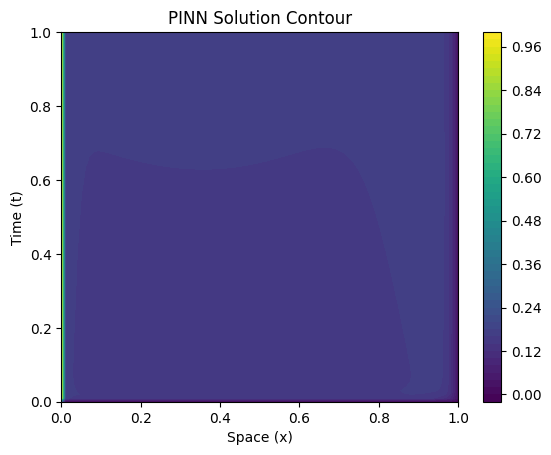

In [57]:
plt.contourf(X_test, T_test, U_pred, levels=50, cmap='viridis')
plt.colorbar()
plt.xlabel('Space (x)')
plt.ylabel('Time (t)')
plt.title('PINN Solution Contour')
plt.show()

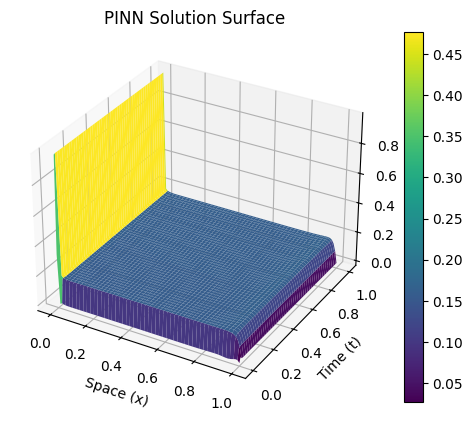

In [58]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X_test, T_test, U_pred, cmap='viridis', edgecolor='none')
fig.colorbar(surf)
ax.set_xlabel('Space (x)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('Solution (u)')
ax.set_title('PINN Solution Surface')
plt.show()